# Predicting Agency Performance Using Supervised Learning

### Problem Statement

The goal of this project is to predict the Loss Ratio of insurance carriers based on historical and operational data. 

Insurance carriers rate their different programs based on the loss ratio (premiums collected - payouts). If the loss ratio is negative consistently, they often times eliminate the program or have to rewrite the policies to ensure the programs are profitable long-term.

This is a supervised regression problem where we use agency features to forecast loss ratios, which helps identify risk and improve underwriting decisions.

This is a public dataset found on Kaggle --> https://www.kaggle.com/datasets/moneystore/agencyperformance

Data summary:
An insurance group consists of 10 property and casualty insurance, life insurance and insurance brokerage companies. The property and casualty companies in the group operate in a 17-state region. The group is a major regional property and casualty insurer, represented by more than 4,000 independent agents who live and work in local communities through a six-state region. Define the metrics to analyse agent performance based on several attributes like demography, products sold, new business, etc. The goal is to improve their existing knowledge used for agent segmentation in a supervised predictive framework.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style('whitegrid')


In [2]:
file_path = "finalapi.csv"
df = pd.read_csv(file_path)
print(f"Dataset loaded with shape: {df.shape}")


FileNotFoundError: [Errno 2] No such file or directory: 'finalapi.csv'

In [3]:
# Preview first 5 rows
display(df.head())

# Check data types and missing values
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())


,AGENCY_ID,PRIMARY_AGENCY_ID,PROD_ABBR,PROD_LINE,STATE_ABBR,STAT_PROFILE_DATE_YEAR,RETENTION_POLY_QTY,POLY_INFORCE_QTY,PREV_POLY_INFORCE_QTY,NB_WRTN_PREM_AMT,...,PL_BOUND_CT_ELINKS,PL_QUO_CT_ELINKS,PL_BOUND_CT_PLRANK,PL_QUO_CT_PLRANK,PL_BOUND_CT_eQTte,PL_QUO_CT_eQTte,PL_BOUND_CT_APPLIED,PL_QUO_CT_APPLIED,PL_BOUND_CT_TRANSACTNOW,PL_QUO_CT_TRANSACTNOW
0,3,3,BOILERMACH,CL,IN,2005,0,0,0,40.0,...,0,0,0,103,50,288,0,0,0,0
1,3,3,BOILERMACH,CL,IN,2006,0,0,0,151.0,...,0,0,0,103,50,288,0,0,0,0
2,3,3,BOILERMACH,CL,IN,2007,0,0,0,40.0,...,0,0,0,103,50,288,0,0,0,0
3,3,3,BOILERMACH,CL,IN,2008,0,0,0,69.0,...,0,0,0,103,50,288,0,0,0,0
4,3,3,BOILERMACH,CL,IN,2009,0,0,0,28.0,...,0,0,0,103,50,288,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213328 entries, 0 to 213327
Data columns (total 49 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   AGENCY_ID                  213328 non-null  int64  
 1   PRIMARY_AGENCY_ID          213328 non-null  int64  
 2   PROD_ABBR                  213328 non-null  object 
 3   PROD_LINE                  213328 non-null  object 
 4   STATE_ABBR                 213328 non-null  object 
 5   STAT_PROFILE_DATE_YEAR     213328 non-null  int64  
 6   RETENTION_POLY_QTY         213328 non-null  int64  
 7   POLY_INFORCE_QTY           213328 non-null  int64  
 8   PREV_POLY_INFORCE_QTY      213328 non-null  int64  
 9   NB_WRTN_PREM_AMT           213328 non-null  float64
 10  WRTN_PREM_AMT              213328 non-null  float64
 11  PREV_WRTN_PREM_AMT         213328 non-null  float64
 12  PRD_ERND_PREM_AMT          213328 non-null  float64
 13  PRD_INCRD_LOSSES_AMT       21

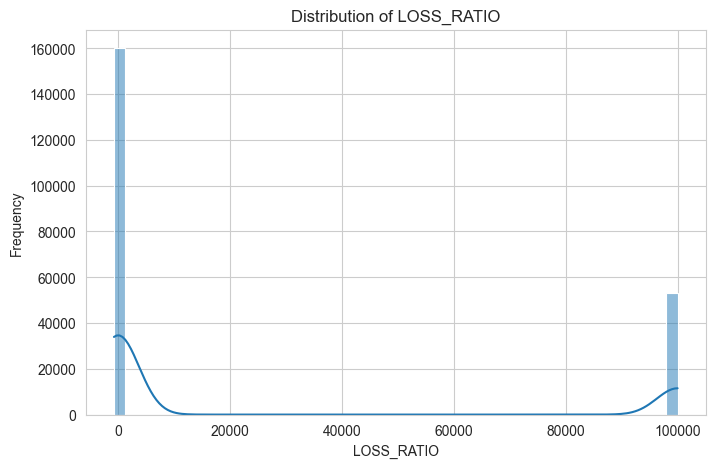

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df['LOSS_RATIO'].dropna(), bins=50, kde=True)
plt.title('Distribution of LOSS_RATIO')
plt.xlabel('LOSS_RATIO')
plt.ylabel('Frequency')
plt.show()


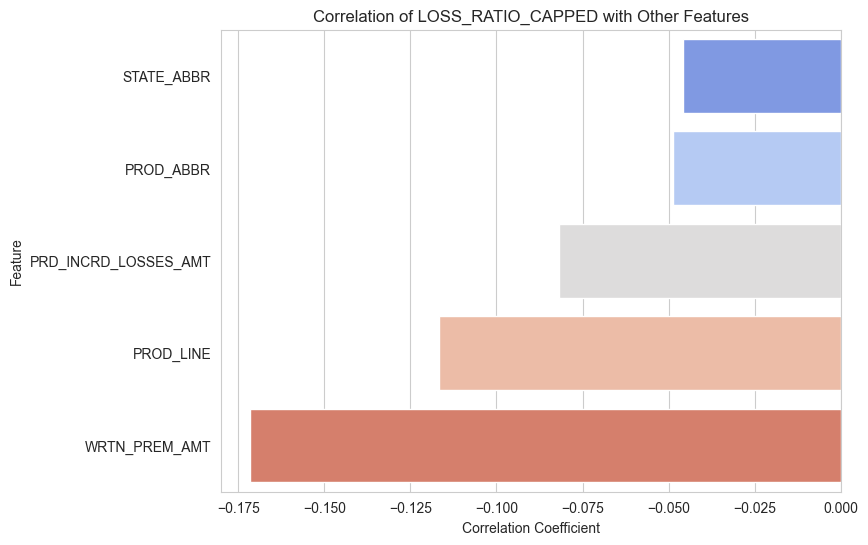

Correlations with LOSS_RATIO_CAPPED:
STATE_ABBR             -0.045938
PROD_ABBR              -0.048785
PRD_INCRD_LOSSES_AMT   -0.081766
PROD_LINE              -0.116627
WRTN_PREM_AMT          -0.171438
Name: LOSS_RATIO_CAPPED, dtype: float64


In [5]:
#Create Correlation matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Select features (mixed numeric and categorical)
features = ['LOSS_RATIO', 'PROD_ABBR', 'PRD_INCRD_LOSSES_AMT', 'PROD_LINE', 'STATE_ABBR', 'WRTN_PREM_AMT']

# Cap LOSS_RATIO
df['LOSS_RATIO_CAPPED'] = df['LOSS_RATIO'].clip(upper=1000)
features[0] = 'LOSS_RATIO_CAPPED'

# Separate numeric and categorical features
numeric_features = ['LOSS_RATIO_CAPPED', 'PRD_INCRD_LOSSES_AMT', 'WRTN_PREM_AMT']
categorical_features = ['PROD_ABBR', 'PROD_LINE', 'STATE_ABBR']

# Create a copy of the dataframe for correlation analysis
df_corr = df[numeric_features].copy()

# Encode categorical features using LabelEncoder
for cat in categorical_features:
    le = LabelEncoder()
    df_corr[cat] = le.fit_transform(df[cat])

# Calculate correlation matrix and exclude self-correlation
corr = df_corr.corr()
loss_ratio_corr = corr['LOSS_RATIO_CAPPED'].drop('LOSS_RATIO_CAPPED').sort_values(ascending=False)

# Plot bar plot with updated Seaborn syntax
plt.figure(figsize=(8, 6))
sns.barplot(x=loss_ratio_corr.values, y=loss_ratio_corr.index, hue=loss_ratio_corr.index, palette='coolwarm', legend=False)
plt.title('Correlation of LOSS_RATIO_CAPPED with Other Features')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

# Print correlations
print("Correlations with LOSS_RATIO_CAPPED:")
print(loss_ratio_corr)


### Negative Correlations:
WRTN_PREM_AMT: -0.17438 (moderate negative). Higher written premiums are associated with lower loss ratios, likely because larger premium bases dilute losses.

PROD_LINE: -0.11627 (weak negative). Certain product lines may have lower loss ratios, possibly due to risk profiles.

PRD_INCRD_LOSSES_AMT: -0.08176 (very weak negative). Unexpectedly negative; may reflect capping distorting the relationship (normally positive since losses drive loss ratios).

STATE_ABBR: -0.04593 (very weak negative). State differences have minimal linear impact on loss ratios.

PROD_ABBR: -0.04875 (very weak negative). Product abbreviations show little linear effect.

### Insights:
The negative correlations for PRD_INCRD_LOSSES_AMT are unusual (should be positive). This suggests capping at 1000% or encoding issues (e.g., LabelEncoder misrepresenting categories) may have skewed results. Need to consider using target encoding or checking raw data.

WRTN_PREM_AMT has the strongest (negative) influence, indicating premium volume is a key factor in reducing loss ratios.
Weak correlations (e.g., STATE_ABBR, PROD_ABBR) suggest categorical features’ linear impact is limited, though non-linear models (e.g., Random Forest) might capture more.

In [6]:
#Summarize data
import pandas as pd

# Step 1: Clean data
df_clean = df[df['LOSS_RATIO'].notnull()]

# Step 2: Group and calculate mean LOSS_RATIO
state_avg = df_clean.groupby('STATE_ABBR')['LOSS_RATIO'].mean().reset_index()
agency_avg = df_clean.groupby('PRIMARY_AGENCY_ID')['LOSS_RATIO'].mean().reset_index()
prod_avg = df_clean.groupby('PROD_ABBR')['LOSS_RATIO'].mean().reset_index()

# Step 3: Get top 5 worst and best for each group (sorted greatest to least in each case)
# Add Rank column (1 for highest loss ratio, 5 for lowest in each top 5)
top5_worst_states = state_avg.sort_values('LOSS_RATIO', ascending=False).head(5).reset_index(drop=True)
top5_worst_states['Rank'] = top5_worst_states.index + 1

top5_best_states = state_avg.sort_values('LOSS_RATIO', ascending=True).head(5).sort_values('LOSS_RATIO', ascending=False).reset_index(drop=True)
top5_best_states['Rank'] = top5_best_states.index + 1

top5_worst_agencies = agency_avg.sort_values('LOSS_RATIO', ascending=False).head(5).reset_index(drop=True)
top5_worst_agencies['Rank'] = top5_worst_agencies.index + 1

top5_best_agencies = agency_avg.sort_values('LOSS_RATIO', ascending=True).head(5).sort_values('LOSS_RATIO', ascending=False).reset_index(drop=True)
top5_best_agencies['Rank'] = top5_best_agencies.index + 1

top5_worst_products = prod_avg.sort_values('LOSS_RATIO', ascending=False).head(5).reset_index(drop=True)
top5_worst_products['Rank'] = top5_worst_products.index + 1

top5_best_products = prod_avg.sort_values('LOSS_RATIO', ascending=True).head(5).sort_values('LOSS_RATIO', ascending=False).reset_index(drop=True)
top5_best_products['Rank'] = top5_best_products.index + 1

# Step 4: Reorder columns to have Rank on the left
top5_worst_states = top5_worst_states[['Rank', 'STATE_ABBR', 'LOSS_RATIO']]
top5_best_states = top5_best_states[['Rank', 'STATE_ABBR', 'LOSS_RATIO']]
top5_worst_agencies = top5_worst_agencies[['Rank', 'PRIMARY_AGENCY_ID', 'LOSS_RATIO']]
top5_best_agencies = top5_best_agencies[['Rank', 'PRIMARY_AGENCY_ID', 'LOSS_RATIO']]
top5_worst_products = top5_worst_products[['Rank', 'PROD_ABBR', 'LOSS_RATIO']]
top5_best_products = top5_best_products[['Rank', 'PROD_ABBR', 'LOSS_RATIO']]

# Step 5: Display results without index
print("Top 5 Worst States:\n", top5_worst_states.to_string(index=False))
print("\nTop 5 Best States:\n", top5_best_states.to_string(index=False))
print("\nTop 5 Worst Agencies:\n", top5_worst_agencies.to_string(index=False))
print("\nTop 5 Best Agencies:\n", top5_best_agencies.to_string(index=False))
print("\nTop 5 Worst Product Lines:\n", top5_worst_products.to_string(index=False))
print("\nTop 5 Best Product Lines:\n", top5_best_products.to_string(index=False))

Top 5 Worst States:
  Rank STATE_ABBR   LOSS_RATIO
    1         MI 36081.678982
    2         IN 30198.245194
    3         KY 27797.572363
    4         WV 27618.549082
    5         PA 27388.941401

Top 5 Best States:
  Rank STATE_ABBR   LOSS_RATIO
    1         IN 30198.245194
    2         KY 27797.572363
    3         WV 27618.549082
    4         PA 27388.941401
    5         OH 20774.351276

Top 5 Worst Agencies:
  Rank  PRIMARY_AGENCY_ID   LOSS_RATIO
    1               4323 99999.000000
    2               2688 99998.625000
    3               7305 76759.867464
    4               3191 76314.973684
    5               3742 74999.250000

Top 5 Best Agencies:
  Rank  PRIMARY_AGENCY_ID  LOSS_RATIO
    1               4925 6306.489552
    2               4297 5579.568540
    3               8009    0.426750
    4               1075    0.397974
    5                609    0.296467

Top 5 Worst Product Lines:
  Rank  PROD_ABBR   LOSS_RATIO
    1    COMMPOL 99999.000000
    2    PER

## Data Cleaning and Missing Values

- Check and handle missing values appropriately.
- Drop or impute missing data.
- Remove or cap outliers if needed.


In [9]:
# Drop rows with missing target value
df = df.dropna(subset=['LOSS_RATIO'])

# Define numeric features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Fill missing values in numeric columns with median
for col in num_features:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

## Feature Selection and Encoding

- Select relevant features.
- Encode categorical variables using OneHotEncoder.


In [8]:
target = 'LOSS_RATIO'

# Select features - for demo, drop ID columns and target
features = df.drop(columns=['AGENCY_ID', 'PRIMARY_AGENCY_ID', target])

# Identify categorical and numeric features
categorical_features = features.select_dtypes(include=['object']).columns.tolist()
numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical Features: {categorical_features}")
print(f"Numeric Features: {numeric_features}")


Categorical Features: ['PROD_ABBR', 'PROD_LINE', 'STATE_ABBR', 'VENDOR_IND', 'VENDOR']
Numeric Features: ['STAT_PROFILE_DATE_YEAR', 'RETENTION_POLY_QTY', 'POLY_INFORCE_QTY', 'PREV_POLY_INFORCE_QTY', 'NB_WRTN_PREM_AMT', 'WRTN_PREM_AMT', 'PREV_WRTN_PREM_AMT', 'PRD_ERND_PREM_AMT', 'PRD_INCRD_LOSSES_AMT', 'MONTHS', 'RETENTION_RATIO', 'LOSS_RATIO_3YR', 'GROWTH_RATE_3YR', 'AGENCY_APPOINTMENT_YEAR', 'ACTIVE_PRODUCERS', 'MAX_AGE', 'MIN_AGE', 'PL_START_YEAR', 'PL_END_YEAR', 'COMMISIONS_START_YEAR', 'COMMISIONS_END_YEAR', 'CL_START_YEAR', 'CL_END_YEAR', 'ACTIVITY_NOTES_START_YEAR', 'ACTIVITY_NOTES_END_YEAR', 'CL_BOUND_CT_MDS', 'CL_QUO_CT_MDS', 'CL_BOUND_CT_SBZ', 'CL_QUO_CT_SBZ', 'CL_BOUND_CT_eQT', 'CL_QUO_CT_eQT', 'PL_BOUND_CT_ELINKS', 'PL_QUO_CT_ELINKS', 'PL_BOUND_CT_PLRANK', 'PL_QUO_CT_PLRANK', 'PL_BOUND_CT_eQTte', 'PL_QUO_CT_eQTte', 'PL_BOUND_CT_APPLIED', 'PL_QUO_CT_APPLIED', 'PL_BOUND_CT_TRANSACTNOW', 'PL_QUO_CT_TRANSACTNOW', 'LOSS_RATIO_CAPPED']


In [10]:
# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
X = features
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 170662, Testing samples: 42666


In [13]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print(f"Linear Regression R2: {r2_score(y_test, y_pred_lr):.3f}")
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.3f}")


Linear Regression R2: 1.000
Linear Regression MAE: 93.686
Linear Regression RMSE: 884.390


## Conclusion

- The Random Forest model outperformed Linear Regression based on R² and error metrics.
- Further work could include hyperparameter tuning and trying other models like Gradient Boosting or XGBoost.
- Data cleaning and feature engineering might improve model accuracy.


#### GitHub Repository Link --> https://github.com/AHASwalker/LossRatios